# Install needed libraries

In [1]:
!pip install tensorflow==2.3.0
!pip install gym

# Setup the Project

In [2]:
!pip install -e .

Obtaining file:///Users/georgio/Documents/GitHub/gym_MLAA
  Attempting uninstall: gym-MLAA
    Found existing installation: gym-MLAA 0.1
    Uninstalling gym-MLAA-0.1:
      Successfully uninstalled gym-MLAA-0.1
  Running setup.py develop for gym-MLAA


# Import Needed libraries

In [3]:
import gym 
import random
import sys
import numpy as np
import math

# Import the game environment

In [4]:
import gym_MLAA
env = gym.make('maze-random-5x5-v0')
#env = gym.make('maze-random-10x10-plus-v0')
#env = gym.make(maze-random-30x30-plus-v0)

states = env.observation_space
actions = env.action_space
print(states)
print(actions)

pygame 2.1.2 (SDL 2.0.18, Python 3.8.8)
Hello from the pygame community. https://www.pygame.org/contribute.html
Box([0 0], [4 4], (2,), int64)
Discrete(4)


# Setting Env and Training Constants

In [13]:
'''
Defining the environment related constants
'''
# Number of discrete states (bucket) per state dimension
MAZE_SIZE = tuple((env.observation_space.high + np.ones(env.observation_space.shape)).astype(int))
NUM_BUCKETS = MAZE_SIZE  # one bucket per grid

# Number of discrete actions
NUM_ACTIONS = env.action_space.n  # ["N", "S", "E", "W"]
# Bounds for each discrete state
STATE_BOUNDS = list(zip(env.observation_space.low, env.observation_space.high))

'''
Learning related constants
'''
MIN_EXPLORE_RATE = 0.001
MIN_LEARNING_RATE = 0.2
DECAY_FACTOR = np.prod(MAZE_SIZE, dtype=float) / 10.0

'''
Defining the simulation related constants
'''
NUM_EPISODES = 50000
MAX_T = np.prod(MAZE_SIZE, dtype=int) * 100
STREAK_TO_END = 100
SOLVED_T = np.prod(MAZE_SIZE, dtype=int)
#DEBUG_MODE = 0
RENDER_MAZE = True
ENABLE_RECORDING = True

'''
Creating a Q-Table for each state-action pair
'''
q_table = np.zeros(NUM_BUCKETS + (NUM_ACTIONS,), dtype=float)

'''
Begin simulation
'''
recording_folder = "/tmp/maze_q_learning"


# Define Helper Functions

In [14]:
def select_action(state, explore_rate):
    # Select a random action
    if random.random() < explore_rate:
        action = env.action_space.sample()
    # Select the action with the highest q
    else:
        action = int(np.argmax(q_table[state]))
    return action


def get_explore_rate(t):
    return max(MIN_EXPLORE_RATE, min(0.8, 1.0 - math.log10((t+1)/DECAY_FACTOR)))


def get_learning_rate(t):
    return max(MIN_LEARNING_RATE, min(0.8, 1.0 - math.log10((t+1)/DECAY_FACTOR)))


def state_to_bucket(state):
    bucket_indice = []
    for i in range(len(state)):
        if state[i] <= STATE_BOUNDS[i][0]:
            bucket_index = 0
        elif state[i] >= STATE_BOUNDS[i][1]:
            bucket_index = NUM_BUCKETS[i] - 1
        else:
            # Mapping the state bounds to the bucket array
            bound_width = STATE_BOUNDS[i][1] - STATE_BOUNDS[i][0]
            offset = (NUM_BUCKETS[i]-1)*STATE_BOUNDS[i][0]/bound_width
            scaling = (NUM_BUCKETS[i]-1)/bound_width
            bucket_index = int(round(scaling*state[i] - offset))
        bucket_indice.append(bucket_index)
    return tuple(bucket_indice)

# Q Learning

In [7]:
Q_timeSteps_list = []
Q_TotalReward_list = []
Q_Episodes_list = []

In [8]:
# Instantiating the learning related parameters
learning_rate = get_learning_rate(0)
explore_rate = get_explore_rate(0)
discount_factor = 0.99

num_streaks = 0

# Render tha maze
env.render()

for episode in range(NUM_EPISODES):

    # Reset the environment
    obv = env.reset()

    # the initial state
    state_0 = state_to_bucket(obv)
    action = select_action(state_0, explore_rate)
    total_reward = 0

    for t in range(MAX_T):

        # execute the action
        obv, reward, done, _ = env.step(action)

        # Observe the result
        state = state_to_bucket(obv)
        total_reward += reward
        
        # Select an action
        action = select_action(state_0, explore_rate)

        # Update the Q based on the result
        best_q = np.amax(q_table[state])
        q_table[state_0 + (action,)] += learning_rate * (reward + discount_factor * (best_q) - q_table[state_0 + (action,)])
        #q_table[state_0 + (action,)] += learning_rate * (reward + discount_factor * q_table[state_0 + (action,)] - q_table[state_0 + (action,)])
        
        # Setting up for the next iteration
        state_0 = state

        # Render tha maze
        if RENDER_MAZE:
            env.render()

        if env.is_game_over():
            sys.exit()

        if done:
            print("Episode %d finished after %f time steps with total reward = %f (streak %d)."
                  % (episode, t, total_reward, num_streaks))
            Q_Episodes_list.append(episode)
            Q_timeSteps_list.append(t)
            Q_TotalReward_list.append(total_reward)
            
            if t <= SOLVED_T:
                num_streaks += 1
            else:
                num_streaks = 0
            break

        elif t >= MAX_T - 1:
            print("Episode %d timed out at %d with total reward = %f."
                  % (episode, t, total_reward))

    # It's considered done when it's solved over 120 times consecutively
    if num_streaks > STREAK_TO_END:
        break

    # Update parameters
    explore_rate = get_explore_rate(episode)
    learning_rate = get_learning_rate(episode)

Episode 0 finished after 15.000000 time steps with total reward = 0.472000 (streak 0).
Episode 1 finished after 22.000000 time steps with total reward = 0.444000 (streak 1).
Episode 2 finished after 93.000000 time steps with total reward = -1.712000 (streak 2).
Episode 3 finished after 17.000000 time steps with total reward = 0.464000 (streak 0).
Episode 4 finished after 17.000000 time steps with total reward = 0.536000 (streak 1).
Episode 5 finished after 54.000000 time steps with total reward = -0.080000 (streak 2).
Episode 6 finished after 241.000000 time steps with total reward = -4.788000 (streak 0).
Episode 7 finished after 214.000000 time steps with total reward = -4.248000 (streak 0).
Episode 8 finished after 150.000000 time steps with total reward = -3.092000 (streak 0).
Episode 9 finished after 272.000000 time steps with total reward = -5.884000 (streak 0).
Episode 10 finished after 207.000000 time steps with total reward = -3.896000 (streak 0).
Episode 11 finished after 145.

Episode 95 finished after 7.000000 time steps with total reward = 0.792000 (streak 20).
Episode 96 finished after 7.000000 time steps with total reward = 0.792000 (streak 21).
Episode 97 finished after 7.000000 time steps with total reward = 0.792000 (streak 22).
Episode 98 finished after 7.000000 time steps with total reward = 0.792000 (streak 23).
Episode 99 finished after 7.000000 time steps with total reward = 0.792000 (streak 24).
Episode 100 finished after 7.000000 time steps with total reward = 0.792000 (streak 25).
Episode 101 finished after 7.000000 time steps with total reward = 0.792000 (streak 26).
Episode 102 finished after 7.000000 time steps with total reward = 0.792000 (streak 27).
Episode 103 finished after 7.000000 time steps with total reward = 0.792000 (streak 28).
Episode 104 finished after 7.000000 time steps with total reward = 0.792000 (streak 29).
Episode 105 finished after 7.000000 time steps with total reward = 0.792000 (streak 30).
Episode 106 finished after

In [9]:
print(Q_TotalReward_list)
print(Q_timeSteps_list)
print(Q_Episodes_list)

[0.4720000000000001, 0.44400000000000006, -1.7120000000000015, 0.4640000000000001, 0.536, -0.08000000000000052, -4.787999999999995, -4.248000000000002, -3.0920000000000023, -5.8839999999999835, -3.8959999999999946, -2.8560000000000025, 0.5880000000000001, -1.0720000000000014, -2.0120000000000022, 0.616, -3.0400000000000027, -2.420000000000002, -0.9120000000000013, -0.9880000000000011, -4.583999999999988, -5.435999999999999, 0.23199999999999987, -5.739999999999976, 0.66, 0.836, 0.19199999999999984, -0.49600000000000066, 0.352, 0.31199999999999994, -4.911999999999993, -17.087999999999738, -1.004000000000001, 0.1559999999999998, 0.1559999999999998, -5.1479999999999855, -0.2040000000000004, -0.47200000000000064, -2.116000000000002, 0.07199999999999973, 0.836, 0.23199999999999987, 0.09999999999999976, -5.371999999999986, 0.712, -0.5760000000000007, 0.752, 0.06799999999999973, -0.0920000000000003, 0.752, -0.4520000000000006, -0.38000000000000056, 0.5080000000000001, 0.2719999999999997, 0.508

# Plot Q-Learning Results

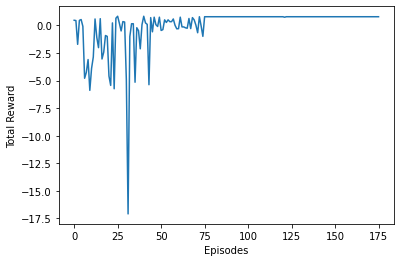

In [10]:
# importing the required module
import matplotlib.pyplot as plt
 
# plotting the points
plt.plot(Q_Episodes_list, Q_TotalReward_list)
 
# naming the x axis
plt.xlabel('Episodes')
# naming the y axis
plt.ylabel('Total Reward')
 
# giving a title to my graph
#plt.title('My first graph!')
 
# function to show the plot
plt.show()

# SARSA

In [15]:
S_timeSteps_list = []
S_TotalReward_list = []
S_Episodes_list = []

In [16]:
# Instantiating the learning related parameters
learning_rate = get_learning_rate(0)
explore_rate = get_explore_rate(0)
discount_factor = 0.99

num_streaks = 0

# Render tha maze
env.render()

for episode in range(NUM_EPISODES):

    # Reset the environment
    obv = env.reset()

    # the initial state
    state_0 = state_to_bucket(obv)
    total_reward = 0

    for t in range(MAX_T):

        # execute the action
        obv, reward, done, _ = env.step(action)

        # Observe the result
        state = state_to_bucket(obv)
        total_reward += reward
        
        # Select an action
        action_new = select_action(state, explore_rate)

        # Update the Q based on the result
        #best_q = np.amax(q_table[state])
        #q_table[state_0 + (action,)] += learning_rate * (reward + discount_factor * (best_q) - q_table[state_0 + (action,)])
        q_table[state_0 + (action,)] += learning_rate * (reward + discount_factor * q_table[state + (action_new,)] - q_table[state_0 + (action,)])
        
        # Setting up for the next iteration
        state_0 = state
        action = action_new

        # Render tha maze
        if RENDER_MAZE:
            env.render()

        if env.is_game_over():
            sys.exit()

        if done:
            print("Episode %d finished after %f time steps with total reward = %f (streak %d)."
                  % (episode, t, total_reward, num_streaks))
            S_Episodes_list.append(episode)
            S_timeSteps_list.append(t)
            S_TotalReward_list.append(total_reward)
            
            if t <= SOLVED_T:
                num_streaks += 1
            else:
                num_streaks = 0
            break

        elif t >= MAX_T - 1:
            print("Episode %d timed out at %d with total reward = %f."
                  % (episode, t, total_reward))

    # It's considered done when it's solved over 120 times consecutively
    if num_streaks > STREAK_TO_END:
        break

    # Update parameters
    explore_rate = get_explore_rate(episode)
    learning_rate = get_learning_rate(episode)

Episode 0 finished after 14.000000 time steps with total reward = 0.548000 (streak 0).
Episode 1 finished after 117.000000 time steps with total reward = -1.124000 (streak 1).
Episode 2 finished after 52.000000 time steps with total reward = -0.612000 (streak 0).
Episode 3 finished after 46.000000 time steps with total reward = 0.096000 (streak 0).
Episode 4 finished after 112.000000 time steps with total reward = -1.860000 (streak 0).
Episode 5 finished after 22.000000 time steps with total reward = 0.588000 (streak 0).
Episode 6 finished after 41.000000 time steps with total reward = 0.476000 (streak 1).
Episode 7 finished after 45.000000 time steps with total reward = 0.208000 (streak 0).
Episode 8 finished after 92.000000 time steps with total reward = -1.276000 (streak 0).
Episode 9 finished after 23.000000 time steps with total reward = 0.368000 (streak 0).
Episode 10 finished after 37.000000 time steps with total reward = -0.192000 (streak 1).
Episode 11 finished after 5.000000 

Episode 94 finished after 5.000000 time steps with total reward = 0.836000 (streak 76).
Episode 95 finished after 5.000000 time steps with total reward = 0.836000 (streak 77).
Episode 96 finished after 5.000000 time steps with total reward = 0.836000 (streak 78).
Episode 97 finished after 5.000000 time steps with total reward = 0.836000 (streak 79).
Episode 98 finished after 5.000000 time steps with total reward = 0.836000 (streak 80).
Episode 99 finished after 5.000000 time steps with total reward = 0.836000 (streak 81).
Episode 100 finished after 5.000000 time steps with total reward = 0.836000 (streak 82).
Episode 101 finished after 5.000000 time steps with total reward = 0.836000 (streak 83).
Episode 102 finished after 5.000000 time steps with total reward = 0.836000 (streak 84).
Episode 103 finished after 5.000000 time steps with total reward = 0.836000 (streak 85).
Episode 104 finished after 5.000000 time steps with total reward = 0.836000 (streak 86).
Episode 105 finished after 

# Plot SARSA result

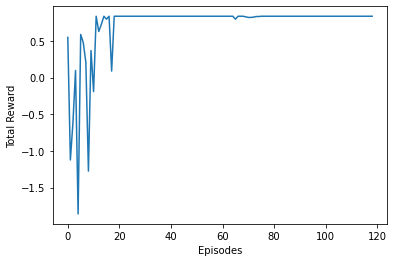

In [17]:
# importing the required module
import matplotlib.pyplot as plt
 
# plotting the points
plt.plot(S_Episodes_list, S_TotalReward_list)
 
# naming the x axis
plt.xlabel('Episodes')
# naming the y axis
plt.ylabel('Total Reward')
 
# giving a title to my graph
#plt.title('My first graph!')
 
# function to show the plot
plt.show()

# DQN

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
class Replay(object):
    #memory for training the DQN
    def __init__(self):
        self.max_size = 100
        self.transitions = []  # (old state, new state, action, reward)

    def store(self, s0, s, a, r):
        self.transitions.append((s0, s, a, r))
        if len(self.transitions) > self.max_size:
            self.transitions.pop(0)

    def sample(self):
        return self.transitions[random.randint(0, len(self.transitions) - 1)]


class DQN(nn.Module):
    def __init__(self):
        super(DQN, self).__init__()
        self.layer1 = nn.LSTM(2, 4, num_layers=32)
        self.layer2 = nn.LSTM(4, 8, num_layers=64)
        self.layer3 = nn.LSTM(8, 16, num_layers=64)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(16, 4)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x, h = self.layer1(x)
        x=self.relu(x)
        x,h=self.layer2(x)
        x=self.relu(x)
        x,h=self.layer3(x)
        x = self.relu(x)
        x = self.fc(x)
        # x = self.sigmoid(x)
        return x

    def test(self):
        pass

    def select_action(self, state, er, device):
        # Select a random action
        if random.random() < er:
            action = env.action_space.sample()
        # Select the action with the highest q
        else:
            with torch.no_grad():
                state = torch.FloatTensor([state[0], state[1]]).view(1, 1, len(state)).to(device)
                val, action = self.forward(state)[0][0].max(0)
                action = action.item()
        return action

In [ ]:

# Instantiating the learning related parameters
discount_factor = 0.99
update_target = 5

num_streaks = 0

# Render the maze
env.render()
dqn = DQN()
device = torch.device('cpu')
dqn = dqn.to(device)
target = DQN()
target = target.to(device)
dqn_opt = optim.Adam(dqn.parameters())
dqn_opt.zero_grad()
replay = Replay()
loss = nn.MSELoss()

for episode in range(NUM_EPISODES):
    # Reset the environment
    obv = env.reset()

    # the initial state
    s0 = state_to_bucket(obv)
    total_reward = 0
    total_loss = 0

    # Update parameters
    explore_rate = get_explore_rate(episode)
    learning_rate = get_learning_rate(episode)

    for t in range(MAX_T):
        # Select an action
        action = dqn.select_action(s0, explore_rate, device)

        # execute the action
        obv, reward, done, _ = env.step(action)

        # Observe the result
        s = state_to_bucket(obv)
        total_reward += reward

        # store the transition
        replay.store(s0, s, action, reward)

        # update the dqn
        r_s0, r_s, r_a, r_r = replay.sample()
        r_s0 = torch.FloatTensor([r_s0[0], r_s0[1]]).view(1, 1, len(r_s0)).to(device)
        r_s = torch.FloatTensor([r_s[0], r_s[1]]).view(1, 1, len(r_s)).to(device)
        dqn_output =dqn.forward(r_s0)
        target_output=target.forward(r_s)
        dqn_opt.zero_grad()
        l = loss(dqn_output, target_output)
        l.backward()
        dqn_opt.step()
        total_loss+=l.item()

        # update the target network
        if episode % update_target == 0:
            target.load_state_dict(dqn.state_dict())

        # Setting up for the next iteration
        s0 = s

        # Render tha maze
        if RENDER_MAZE:
            env.render()

        if env.is_game_over():
            sys.exit()

        if done:
            print("Episode %d finished after %f time steps with total reward = %f, loss = %f (streak %d)."
                  % (episode, t, total_reward, total_loss, num_streaks))

            if t <= SOLVED_T:
                num_streaks += 1
            else:
                num_streaks = 0
            break

        elif t >= MAX_T - 1:
            print("Episode %d timed out at %d with total reward = %f."
                  % (episode, t, total_reward))

    # It's considered done when it's solved over 120 times consecutively
    if num_streaks > STREAK_TO_END:
        break
